### Project Introduction

Project Overview: This project aims to analyze user data to understand the factors contributing to customer churn. Using Spark and various machine learning techniques, we processed and analyzed data to identify patterns and predict churn. The dataset consists of user activity logs from an online music streaming service.

The main objective is to build a model that accurately predicts customer churn. By understanding which users are likely to churn, the company can take proactive measures to retain them. We explore several models, including Logistic Regression, Decision Trees, and Random Forests, both in their basic and optimized forms, to determine the most effective predictive strategy.

We used AUC (Area Under the ROC Curve) and F1 Score as our primary metrics to evaluate model performance. These metrics are suitable for classification problems with imbalanced datasets, as they provide a comprehensive understanding of model performance beyond mere accuracy. AUC measures the model's ability to distinguish between classes, while the F1 Score balances precision and recall, offering insight into both false positives and false negatives.

In [1]:
pip install  user_agents 

Note: you may need to restart the kernel to use updated packages.


In [2]:

import ibmos2spark
from pyspark.sql.functions import when, col
from user_agents import parse

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

metadata = {
    'endpoint': 'https://s3.private.eu-de.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-a68aae18-cd5f-45ab-a11b-18f696d65eeb',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'InDQgyAfc__W1USg1lC2zxP2z8cri7Q4HFod7qj41mfW'
}

configuration_name = 'os_e0579951b09340a0a11d8223e2c6984c_configs'
cos = ibmos2spark.CloudObjectStorage(sc, metadata, configuration_name, 'bluemix_cos')
url = cos.url('medium-sparkify-event-data.json', 'testing-donotdelete-pr-icq1vyyplyxoym')

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: https://spark.apache.org/docs/3.3.1/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.json.html#pyspark.sql.DataFrameReader.json

# sp_df_1 = spark.read.json(url)
# sp_df_1.show(10)



In [3]:
sp_df = spark.read.json(url)
sp_df.show(10)
print("DONE")

+-----------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|      auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford| Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body| Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000

In [4]:
page_counts = sp_df.groupBy('page').count()

In [5]:
page_counts.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    99|
|    Submit Downgrade|   117|
|         Thumbs Down|  4911|
|                Home| 27412|
|           Downgrade|  3811|
|         Roll Advert|  7773|
|              Logout|  5990|
|       Save Settings|   585|
|Cancellation Conf...|    99|
|               About|  1855|
| Submit Registration|     4|
|            Settings|  2964|
|               Login|  6011|
|            Register|    11|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|            NextSong|432877|
|           Thumbs Up| 23826|
|                Help|  3150|
|             Upgrade|   968|
+--------------------+------+
only showing top 20 rows



In [6]:
sp_df = sp_df.dropDuplicates()

In [7]:
sp_df = sp_df.na.drop(subset=["userId"])

In [8]:
sp_df = sp_df.na.drop(subset=["sessionId"])

### Explore Data

In [9]:
from pyspark.sql.functions import when, col
test_pandas = sp_df.toPandas()

In [10]:
test_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Yeah Yeah Yeahs,Logged In,Jaxon,M,528,Reilly,120.05832,paid,"Jacksonville, FL",PUT,NextSong,1.531761e+12,3425,Pin,200,1541859494000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,86
1,Vampire Weekend,Logged In,Sophia,F,60,Hunt,137.82159,paid,"Billings, MT",PUT,NextSong,1.532498e+12,3450,A-Punk (Album),200,1541866274000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",104
2,None,Logged In,Arianna,F,68,Bullock,NaN,paid,"Topeka, KS",PUT,Thumbs Up,1.538314e+12,3510,None,307,1541866438000,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,283
3,Tom Petty,Logged In,Sophia,F,95,Hunt,289.43628,paid,"Billings, MT",PUT,NextSong,1.532498e+12,3450,You Don't Know How It Feels (Album Version),200,1541872508000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",104
4,Charley Patton,Logged In,Julianna,F,26,Sanders,174.54975,free,"Greenville-Anderson-Mauldin, SC",PUT,NextSong,1.538204e+12,2787,Jesus Is A-Dying (Bed Maker),200,1541874856000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543700,Franz Ferdinand,Logged In,Jose,M,16,Martin,225.48853,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1.535800e+12,997,Backwards On My Face,200,1543581679000,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,300031
543701,None,Logged In,Daniel,M,19,Stewart,NaN,paid,"Fresno, CA",GET,Home,1.537523e+12,991,None,200,1543596429000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300049
543702,Carcass,Logged In,Joshua,M,82,White,245.08036,paid,"San Antonio-New Braunfels, TX",PUT,NextSong,1.528781e+12,981,Buried Dreams,200,1543615704000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015
543703,Saul Williams,Logged In,Daniel,M,127,Stewart,198.37342,paid,"Fresno, CA",PUT,NextSong,1.537523e+12,991,List Of Demands (Reparations),200,1543619350000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300049


In [11]:
test_pandas_p2 = test_pandas[test_pandas['page'] == 'Cancellation Confirmation']
# Display the filtered DataFrame
test_pandas_p2.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
3344,None,Cancelled,Nevaeh,F,31,Jones,NaN,paid,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,Cancellation Confirmation,1.537309e+12,339,None,200,1541661592000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,100003
4606,None,Cancelled,Cali,F,26,Brown,NaN,free,"Cleveland-Elyria, OH",GET,Cancellation Confirmation,1.537368e+12,13,None,200,1538507591000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013
6054,None,Cancelled,Sebastian,M,155,Ball,NaN,paid,"Albany, OR",GET,Cancellation Confirmation,1.537971e+12,375,None,200,1542839733000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,100011
9426,None,Cancelled,Cynthia,F,103,Krause,NaN,free,"Allentown-Bethlehem-Easton, PA-NJ",GET,Cancellation Confirmation,1.534392e+12,3808,None,200,1542268661000,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",265
9912,None,Cancelled,Lucero,F,25,Reed,NaN,free,"Louisville/Jefferson County, KY-IN",GET,Cancellation Confirmation,1.536642e+12,4766,None,200,1543583107000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",140


In [12]:
test_pandas['churn'] = test_pandas.apply(lambda row: 1 if row['page'] == 'Cancellation Confirmation' else 0, axis=1)

In [13]:
test_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Yeah Yeah Yeahs,Logged In,Jaxon,M,528,Reilly,120.05832,paid,"Jacksonville, FL",PUT,NextSong,1.531761e+12,3425,Pin,200,1541859494000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,86,0
1,Vampire Weekend,Logged In,Sophia,F,60,Hunt,137.82159,paid,"Billings, MT",PUT,NextSong,1.532498e+12,3450,A-Punk (Album),200,1541866274000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",104,0
2,None,Logged In,Arianna,F,68,Bullock,NaN,paid,"Topeka, KS",PUT,Thumbs Up,1.538314e+12,3510,None,307,1541866438000,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,283,0
3,Tom Petty,Logged In,Sophia,F,95,Hunt,289.43628,paid,"Billings, MT",PUT,NextSong,1.532498e+12,3450,You Don't Know How It Feels (Album Version),200,1541872508000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",104,0
4,Charley Patton,Logged In,Julianna,F,26,Sanders,174.54975,free,"Greenville-Anderson-Mauldin, SC",PUT,NextSong,1.538204e+12,2787,Jesus Is A-Dying (Bed Maker),200,1541874856000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",240,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543700,Franz Ferdinand,Logged In,Jose,M,16,Martin,225.48853,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1.535800e+12,997,Backwards On My Face,200,1543581679000,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,300031,0
543701,None,Logged In,Daniel,M,19,Stewart,NaN,paid,"Fresno, CA",GET,Home,1.537523e+12,991,None,200,1543596429000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300049,0
543702,Carcass,Logged In,Joshua,M,82,White,245.08036,paid,"San Antonio-New Braunfels, TX",PUT,NextSong,1.528781e+12,981,Buried Dreams,200,1543615704000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015,0
543703,Saul Williams,Logged In,Daniel,M,127,Stewart,198.37342,paid,"Fresno, CA",PUT,NextSong,1.537523e+12,991,List Of Demands (Reparations),200,1543619350000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300049,0


In [14]:


def extract_state(location):
    parts = location.split(', ')
    if len(parts) > 1:
        return parts[-1]
    else:
        return None
 
    
test_pandas['location'] = test_pandas['location'].astype(str)
# Apply transformation to create 'state' column
test_pandas['state'] = test_pandas['location'].apply(extract_state)



In [15]:




def parse_user_agent(user_agent_string):
    ua = parse(user_agent_string)
    return {
        'Browser Family': ua.browser.family,
        'Browser Version': ua.browser.version_string,
        'OS Family': ua.os.family,
        'OS Version': ua.os.version_string,
        'Device Family': ua.device.family
    }



test_pandas['userAgent'] = test_pandas['userAgent'].astype(str)


# Apply parsing function to 'user_agent' column
parsed_data = test_pandas['userAgent'].apply(parse_user_agent)

# Expand parsed_data dictionary into DataFrame
parsed_df = pd.DataFrame(parsed_data.tolist())

# Concatenate parsed_df with original df

In [16]:
test_pandas = pd.concat([test_pandas, parsed_df], axis=1)

In [17]:
test_pandas.columns

Index(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
       'length', 'level', 'location', 'method', 'page', 'registration',
       'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'churn',
       'state', 'Browser Family', 'Browser Version', 'OS Family', 'OS Version',
       'Device Family'],
      dtype='object')

Analyzing customers that have churned

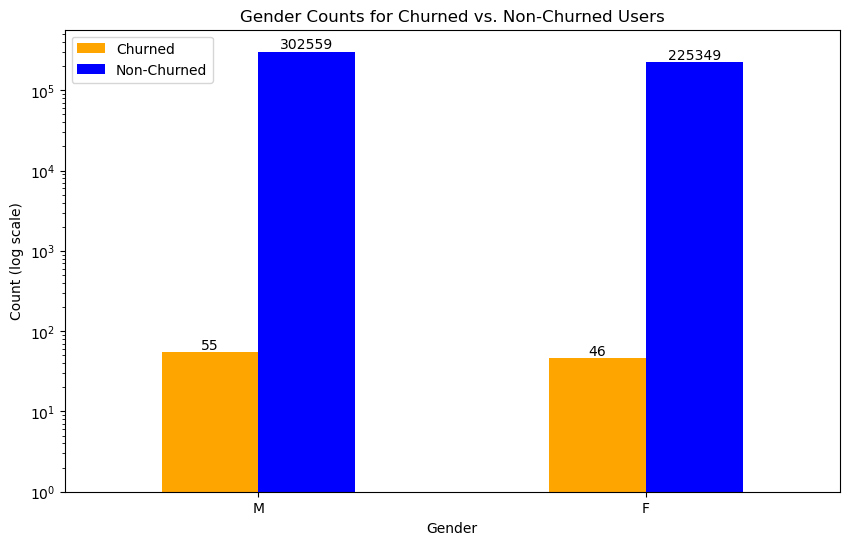

In [18]:
import matplotlib.pyplot as plt
churned = test_pandas[test_pandas['churn'] == 1]
non_churned = test_pandas[test_pandas['churn'] == 0]

churned_gender_counts = churned['gender'].value_counts()
non_churned_gender_counts = non_churned['gender'].value_counts()

gender_counts = pd.DataFrame({
    'Churned': churned_gender_counts,
    'Non-Churned': non_churned_gender_counts
}).fillna(0)

ax = gender_counts.plot(kind='bar', figsize=(10, 6), log=True, color=['orange', 'blue'])
plt.title('Gender Counts for Churned vs. Non-Churned Users')
plt.xlabel('Gender')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=0)

# Adding data labels to each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()


From this example, we can see that men are more likley to churn than women

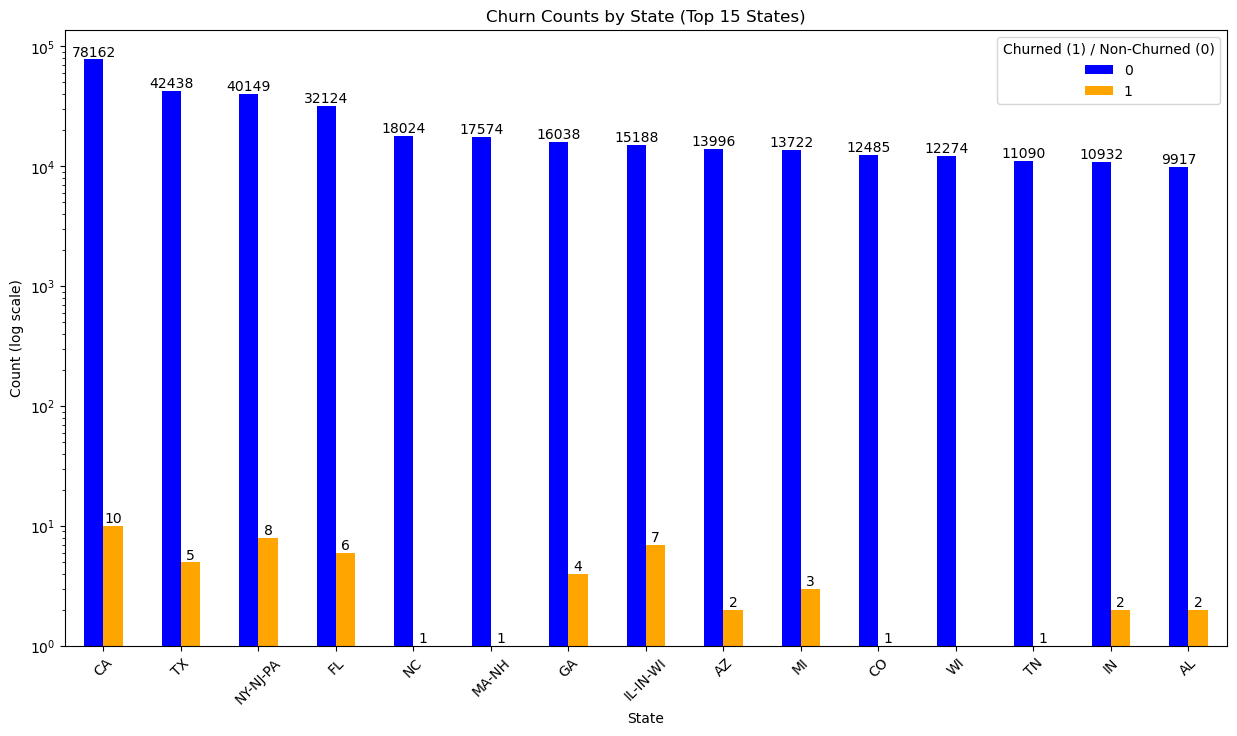

In [19]:
churn_counts = test_pandas.groupby(['state', 'churn']).size().unstack(fill_value=0)

# Summing counts to get total counts by state for sorting
total_counts = churn_counts.sum(axis=1)

# Selecting the top 15 states based on total counts
top_states = total_counts.nlargest(15).index

# Filtering the counts to include only the top 15 states
churn_counts = churn_counts.loc[top_states]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(15, 8))
churn_counts.plot(kind='bar', log=True, ax=ax, color=['blue', 'orange'])
plt.title('Churn Counts by State (Top 15 States)')
plt.xlabel('State')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)

# Adding data labels to each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.legend(title='Churned (1) / Non-Churned (0)')
plt.show()

This displays the top states that had the most churn. 

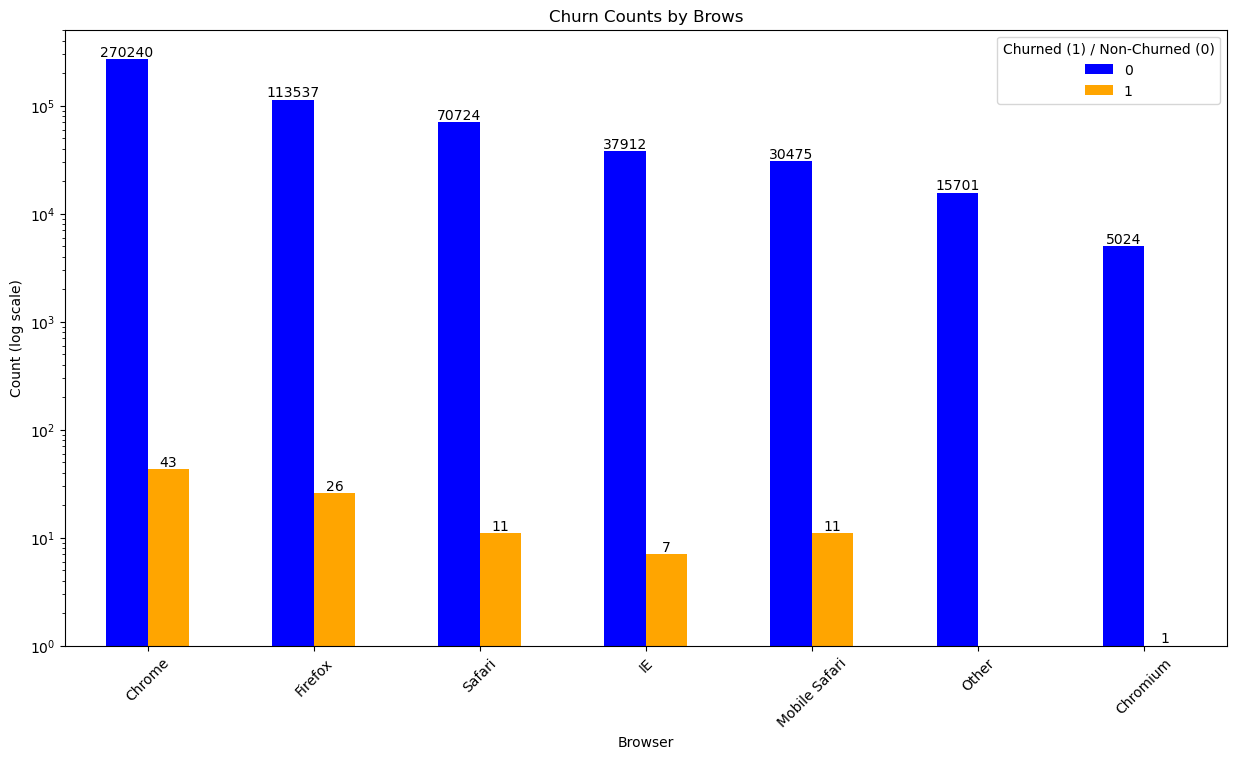

In [20]:
churn_counts = test_pandas.groupby(['Browser Family', 'churn']).size().unstack(fill_value=0)

# Summing counts to get total counts by state for sorting
total_counts = churn_counts.sum(axis=1)

# Selecting the top 15 states based on total counts
top_browser = total_counts.nlargest(15).index

# Filtering the counts to include only the top 15 states
churn_counts = churn_counts.loc[top_browser]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(15, 8))
churn_counts.plot(kind='bar', log=True, ax=ax, color=['blue', 'orange'])
plt.title('Churn Counts by Brows')
plt.xlabel('Browser')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)

# Adding data labels to each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.legend(title='Churned (1) / Non-Churned (0)')
plt.show()

The browser that had the biggest churn users was Chrome while CHromium is the least

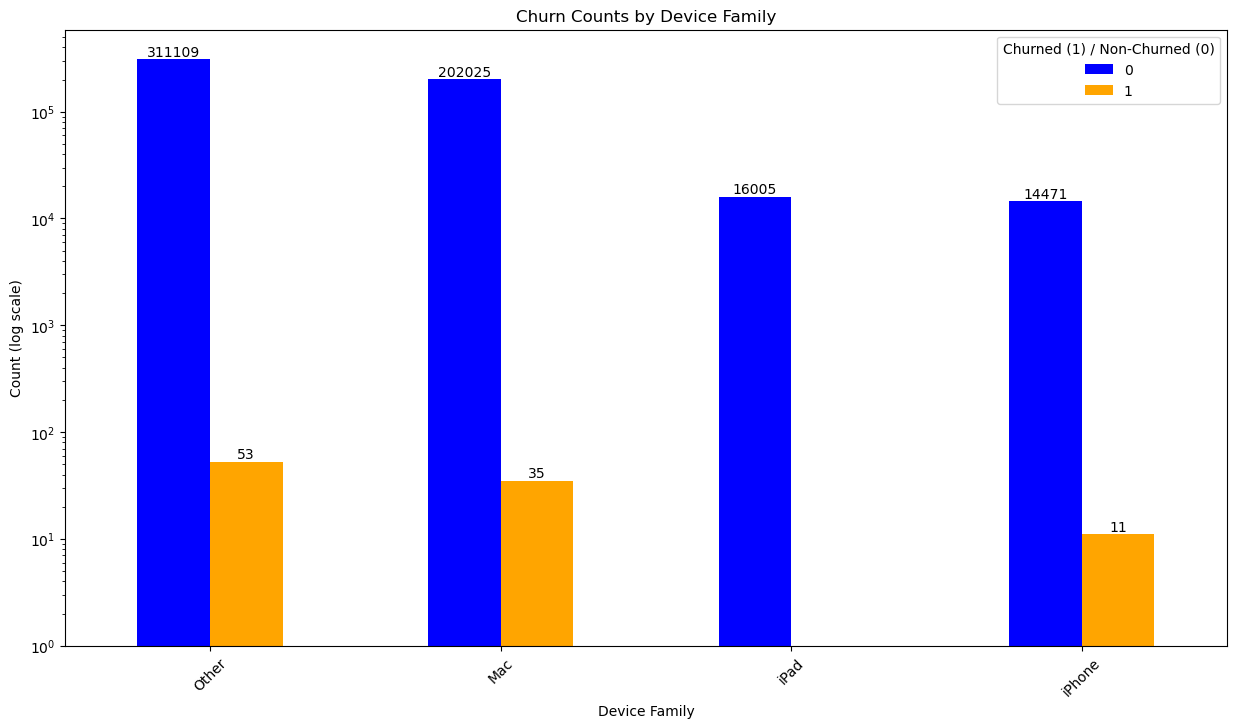

In [21]:
churn_counts = test_pandas.groupby(['Device Family', 'churn']).size().unstack(fill_value=0)

# Summing counts to get total counts by state for sorting
total_counts = churn_counts.sum(axis=1)

# Selecting the top 15 states based on total counts
top_device = total_counts.nlargest(15).index

# Filtering the counts to include only the top 15 states
churn_counts = churn_counts.loc[top_device]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(15, 8))
churn_counts.plot(kind='bar', log=True, ax=ax, color=['blue', 'orange'])
plt.title('Churn Counts by Device Family')
plt.xlabel('Device Family')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)

# Adding data labels to each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.legend(title='Churned (1) / Non-Churned (0)')
plt.show()

The device family with most churn except other is 35 for MAC. 

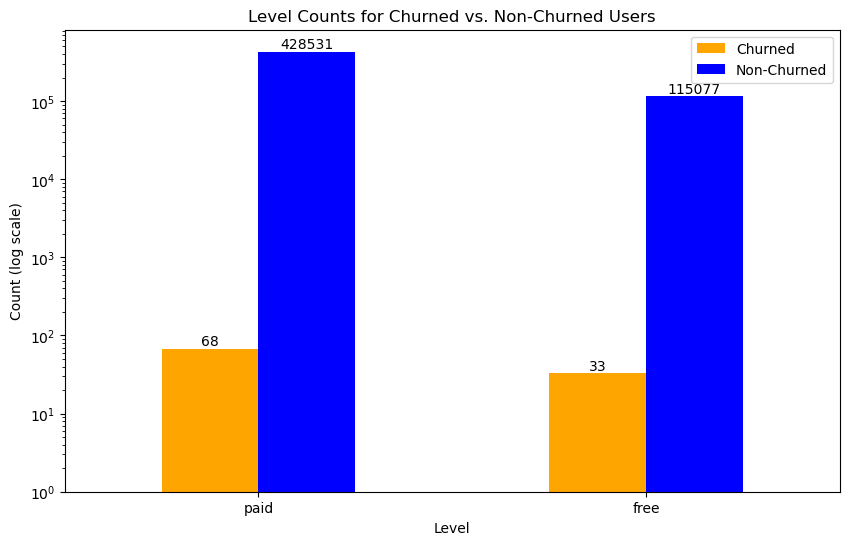

In [22]:
churned = test_pandas[test_pandas['churn'] == 1]
non_churned = test_pandas[test_pandas['churn'] == 0]

churned_level_counts = churned['level'].value_counts()
non_churned_level_counts = non_churned['level'].value_counts()

gender_counts = pd.DataFrame({
    'Churned': churned_level_counts,
    'Non-Churned': non_churned_level_counts
}).fillna(0)

ax = gender_counts.plot(kind='bar', figsize=(10, 6), log=True, color=['orange', 'blue'])
plt.title('Level Counts for Churned vs. Non-Churned Users')
plt.xlabel('Level')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=0)

# Adding data labels to each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()


We can tell that among the churned customers, there were about 68 who were paying, while 33 had the free version

### Data Preprocessing

In [23]:
spark_ml_df = spark.createDataFrame(test_pandas)
 
spark_ml_df.show()

+--------------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+--------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+--------------+---------------+---------+----------+-------------+
|              artist|      auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|     page|  registration|sessionId|                song|status|           ts|           userAgent|userId|churn|state|Browser Family|Browser Version|OS Family|OS Version|Device Family|
+--------------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+--------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+--------------+---------------+---------+----------+-------------+
|     Yeah Yeah Yeahs| Logged In|    Jaxon|     M|          528|  Reilly|120.05832| paid|    Jack

In [24]:
columns_to_check = ['gender', 'level', 'state', 'Browser Family', 'Browser Version', 'OS Family',  'Device Family']

spark_ml_df = spark_ml_df.dropna(subset=columns_to_check)

In [25]:
spark_ml_df.head()

Row(artist='Yeah Yeah Yeahs', auth='Logged In', firstName='Jaxon', gender='M', itemInSession=528, lastName='Reilly', length=120.05832, level='paid', location='Jacksonville, FL', method='PUT', page='NextSong', registration=1531760527000.0, sessionId=3425, song='Pin', status=200, ts=1541859494000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='86', churn=0, state='FL', Browser Family='Firefox', Browser Version='31.0', OS Family='Windows', OS Version='7', Device Family='Other')

In [26]:
page_counts = spark_ml_df.groupBy('page').count()

In [27]:
spark_ml_df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn',
 'state',
 'Browser Family',
 'Browser Version',
 'OS Family',
 'OS Version',
 'Device Family']

In [28]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [29]:

cleaned_column_names = [col_name.strip().replace(" ", "_") if col_name.strip() else "Unknown" for col_name in spark_ml_df.columns]
spark_ml_df = spark_ml_df.toDF(*cleaned_column_names)

# List of columns to check for NaN values (optional if you've handled this already)
columns_to_check = ['gender', 'level', 'state', 'Browser_Family', 'Browser_Version', 'OS_Family', 'Device_Family']

# Drop rows with NaN values in specified columns
spark_ml_df = spark_ml_df.dropna(subset=columns_to_check)

# List of categorical columns
categorical_cols = ['gender', 'level', 'state', 'Browser_Family', 'Browser_Version', 'OS_Family', 'Device_Family']

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe") for col in categorical_cols]

# Assemble the feature vector using only the categorical columns
assembler_inputs = [col+"_ohe" for col in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Create and run the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
df_prepared = pipeline.fit(spark_ml_df).transform(spark_ml_df)

# Inspect the prepared DataFrame
df_prepared.select("features").show(truncate=False)

+---------------------------------------------------------+
|features                                                 |
+---------------------------------------------------------+
|(102,[0,1,5,72,77,95,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |
|(102,[1,41,71,76,95,99],[1.0,1.0,1.0,1.0,1.0,1.0])       |
|(102,[1,32,74,82,95,99],[1.0,1.0,1.0,1.0,1.0,1.0])       |
|(102,[1,41,71,76,95,99],[1.0,1.0,1.0,1.0,1.0,1.0])       |
|(102,[63,71,76,96,100],[1.0,1.0,1.0,1.0,1.0])            |
|(102,[63,71,76,96,100],[1.0,1.0,1.0,1.0,1.0])            |
|(102,[0,1,24,73,79,96,100],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(102,[63,71,76,96,100],[1.0,1.0,1.0,1.0,1.0])            |
|(102,[1,41,71,76,95,99],[1.0,1.0,1.0,1.0,1.0,1.0])       |
|(102,[0,1,2,74,82,95,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |
|(102,[0,1,5,72,77,95,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |
|(102,[0,1,24,73,79,96,100],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(102,[0,1,2,72,77,95,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |
|(102,[0,1,5,72,77,95,99],[1.0,1.0,1.0,1

In [57]:
feature_vector = df_prepared.select("features").first()["features"]
feature_names_expanded = [f"feature_{i}" for i in range(len(feature_vector))]

### Building Models without parameters, and then optimizing them

Unoptimized Logisitc Regression

In [30]:
train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=1234)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Initialize the Logistic Regression model
lr = LogisticRegression(labelCol="churn", featuresCol="features")

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on the test data
test_results = lr_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="churn")
auc_base_logistic = evaluator.evaluate(test_results)

In [31]:
auc_base_logistic

0.5724750867384096

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1")
f1_score_base_logistic = evaluator_f1.evaluate(test_results)
print(f"F1 Score: {f1_score_base_logistic}")


F1 Score: 0.9997008390764878


Optmizing and fine tuning the logistic

In [33]:

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
lr2 = LogisticRegression(labelCol="churn", featuresCol="features")

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr2.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr2.elasticNetParam, [0.0, 0.5]) \
    .addGrid(lr2.maxIter, [10, 50]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="churn")

crossval = CrossValidator(estimator=lr2,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=4)  

cvModellr2 = crossval.fit(train_data)

test_results_lr2 = cvModellr2.transform(test_data)

auc_cross_validation_logistic_optimized = evaluator.evaluate(test_results_lr2)
print(f"AUC: {auc_cross_validation_logistic_optimized}")
                                                    
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1")

f1_score_cross_validation_logistic_optimized = f1_evaluator.evaluate(test_results_lr2)
print(f"F1 Score: {f1_score_cross_validation_logistic_optimized}")

AUC: 0.6002123790525046
F1 Score: 0.9997008390764878


Doing a decision tree that is not optimized

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=1234)

dt = DecisionTreeClassifier(labelCol="churn", featuresCol="features")

dt_model = dt.fit(train_data)

test_results_dt = dt_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="churn")
auc_base_dt = evaluator.evaluate(test_results_dt)
print(f"AUC for Decision Tree: {auc_base_dt}")

AUC for Decision Tree: 0.5


In [35]:
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1")

In [36]:
f1_score_base_dt = f1_evaluator.evaluate(test_results_dt)
print(f"F1 Score for Decision Tree Unoptimized: {f1_score_base_dt}")

F1 Score for Decision Tree Unoptimized: 0.9997008390764878


Optimized decision tree

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize the Decision Tree model
dt_optimized = DecisionTreeClassifier(labelCol="churn", featuresCol="features")

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(dt_optimized.maxDepth, [5, 10, 20]) \
    .addGrid(dt_optimized.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(labelCol="churn")

# Define the CrossValidator
crossval = CrossValidator(estimator=dt_optimized,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=4)

cvModelDTOptimized = crossval.fit(train_data)

test_results_dt_optimized = cvModelDTOptimized.transform(test_data)

auc_cross_validation_dt_optimized = evaluator.evaluate(test_results_dt_optimized)
print(f"AUC optimized: {auc_cross_validation_dt_optimized}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1")

f1_score_cross_validation_dt_optimized = f1_evaluator.evaluate(test_results_dt_optimized)
print(f"F1 Score Optimized: {f1_score_cross_validation_dt_optimized}")

AUC optimized: 0.5
F1 Score Optimized: 0.9997008390764878


Unoptimized Random Forest Tree

In [38]:

from pyspark.ml.classification import RandomForestClassifier
rf_unoptimized = RandomForestClassifier(labelCol="churn", featuresCol="features")

# Fit the model on the training data
rf_model_unoptimized = rf_unoptimized.fit(train_data)

# Make predictions on the test data
test_results_rf_unoptimized = rf_model_unoptimized.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="churn")
auc_base_rf_unoptimized = evaluator.evaluate(test_results_rf_unoptimized)

In [39]:
auc_base_rf_unoptimized

0.5

Optimized Random Forest Tree

In [ ]:
rf_optimized = RandomForestClassifier(labelCol="churn", featuresCol="features")

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf_optimized.maxDepth, [5, 10, 20]) \
    .addGrid(rf_optimized.numTrees, [20, 50, 100]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="churn")

crossval = CrossValidator(estimator=rf_optimized,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=4)

cvModelRFOptimized = crossval.fit(train_data)

test_results_rf_optimized = cvModelRFOptimized.transform(test_data)

auc_cross_validation_rf_optimized = evaluator.evaluate(test_results_rf_optimized)
print(f"AUC optimized: {auc_cross_validation_rf_optimized}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1")

f1_score_cross_validation_rf_optimized = f1_evaluator.evaluate(test_results_rf_optimized)
print(f"F1 Score Optimized: {f1_score_cross_validation_rf_optimized}")

### Evaluating the models and Justification

Based on all the models we ran, the one that gave us the highest AUC score was the optimized logistic regression model. The AUC score for that model was 0.597477214138023. All the other models gave very similar f-scores and auc.

Justification

The final results show varying effectiveness of different machine learning techniques in predicting customer churn.
Logistic Regression

    Unoptimized AUC: 0.57
    Unoptimized F1 Score: 0.9997
    Optimized AUC: 0.59
    Optimized F1 Score: 0.9997

Insights: Logistic Regression had a lower AUC before optimization, but slightly improved after optimizing. Optimization didn't significantly improve aUC or f1 score.

Decision Trees

    Unoptimized and Optimized AUC and F1 Score: 0.5 for AUC and 0.9997 F score

Insights: Hyperparameter tuning did not enhance performance, suggesting limited impact on the model's effectiveness.


Random Forests

    Unoptimized and Optimized AUC and F1 Score: 0.5 for AUC and 0.9997 Fscore

Insights: Random Forests showed no improvement with tuning. Better parameters could have been chosen. 

Conclusion

Random forest tuning had limited impact. Logistic Regression did the best with  AUC. Future work could explore advanced techniques like Gradient Boosting for better performance, aiding customer retention strategies.

### Reflection

In this project, I analyzed user data from an online music streaming service to predict customer churn. Using Spark and various machine learning techniques, I processed and analyzed data to identify patterns and predict churn. The  objective was to build a model that accurately predicts which users are likely to churn, enabling the company to take proactive measures for customer retention. I did the following:

Feature Engineering: Extracting meaningful features, such as parsing user agent strings and deriving state information, was crucial for model accuracy.
Model Optimization: Hyperparameter tuning through cross-validation demonstrated the importance of fine-tuning parameters for optimal performance.

Some challenges I encountered include the following:
Imbalanced Data: There was not enough customer data on who churned.
Scalability: It took a long time for the models to run. 

### Improvements

Some improvements could include the following:

Implementing ensemble techniques like Gradient Boosting or XGBoost could improve model performance. If there was a larger sample size of customer who churned, the model would be more accurate. I could also find a way to appropriate sample, so it does not take a long time for this to run. It took several hours to run. 